# Preprocessing (imputation, standardization, final clean) and modeling
sklearn modeling the median imputed training data using min/max clinically guided aggregation. 
preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss, make_scorer
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
#from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings

#memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('seaborn-white')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 15 ms (started: 2023-07-27 18:34:29 +08:00)


## importing datasets and doing final formatting/processing

In [15]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path, lower_window, upper_window, folder, date, time_col, time_var, patient_df, categorical, save_boolean
#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
stay_id= list(final_pt_df2['stay_id'].unique())
stay_id= [int(x) for x in stay_id]

time: 16 ms (started: 2023-07-27 18:34:29 +08:00)


In [16]:
len(patients) #20464

20464

time: 0 ns (started: 2023-07-27 18:34:29 +08:00)


In [17]:
len(stay_id) #26471

26471

time: 0 ns (started: 2023-07-27 18:34:29 +08:00)


In [18]:
55/7000 

0.007857142857142858

time: 0 ns (started: 2023-07-27 18:34:29 +08:00)


In [19]:
folder

'24_hr_window'

time: 0 ns (started: 2023-07-27 18:34:29 +08:00)


In [20]:
# ###########
# save_boolean=False
# ############

time: 0 ns (started: 2023-07-27 18:34:29 +08:00)


In [21]:
address=str(repository_path)+'/data/cleaned_merged_agg/'+'%s/'%(folder)
train_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'train')), index_col=0)
test_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'test')), index_col=0)
#longneg_data= pd.read_csv(Path(address+'%s_%s_cleaned_merged_agg.csv' %(date, 'longneg')), index_col=0)

time: 141 ms (started: 2023-07-27 18:34:29 +08:00)


In [22]:
### added 11/8/19: removed daily sofa score from prediction model, since the components used to calculate it are already in model
### 12/12/19:  #removing o2_flow since it is mostly sparce and is not a helpful variable
#train_data.drop('daily_sofa', axis=1, inplace=True)
#test_data.drop('daily_sofa', axis=1, inplace=True)
#longneg_data.drop('daily_sofa', axis=1, inplace=True)
train_data.drop('o2_flow', axis=1, inplace=True)
test_data.drop('o2_flow', axis=1, inplace=True)
#longneg_data.drop('o2_flow', axis=1, inplace=True)
categorical.remove('o2_flow')

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [23]:
train_data['pao2fio2ratio'].head()

0    0.216303
1   -0.144873
2    0.216303
3   -0.017479
4    0.216303
Name: pao2fio2ratio, dtype: float64

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


## getting descriptive numbers for publication

In [24]:
final_pt_df2.head()#['stay_id'].nunique()

,stay_id,ssc_charttime,ssc_id,icu_admit,ab_id,ab_start,ab_end,ab_ssc_delta,t_0,t_end,...,t_end_consec,subject_id,dod,ab_course,org_list,spec_type_list,first_pos_else_neg_ssc,sc_result,final_bin,hadm_id
0,37510196,2131-01-10 16:36:00,635,2131-01-11 04:20:05,14800413,2131-01-11 08:00:00,2131-01-20 12:00:00,0 days 15:24:00,2131-01-11 08:00:00,2131-01-20 12:00:00,...,2131-01-20 12:00:00,10001884,2131-01-20,full,NaN,NaN,2131-01-10 16:36:00,negative,C_neg/A_full,26184834
1,33685454,2129-08-05 15:54:00,796,2129-08-04 12:45:00,14801473,2129-08-05 14:00:00,2129-08-10 13:00:00,-1 days +22:06:00,2129-08-05 14:00:00,2129-08-10 13:00:00,...,2129-08-16 09:00:00,10002155,2131-03-10,full,NaN,NaN,2129-08-05 15:54:00,negative,C_neg/A_full,23822395
2,31090461,2130-09-25 11:04:00,822,2130-09-24 00:50:00,14801575,2130-09-25 11:00:00,2130-09-26 11:00:00,-1 days +23:56:00,2130-09-25 11:00:00,2130-09-26 11:00:00,...,2130-09-26 11:00:00,10002155,2131-03-10,partial,NaN,NaN,2130-09-25 11:04:00,negative,C_neg/A_partial,28994087
3,32358465,2131-03-10 00:58:00,828,2131-03-09 21:33:00,14801420,2131-03-10 01:00:00,2131-03-10 14:00:00,0 days 00:02:00,2131-03-10 01:00:00,2131-03-10 14:00:00,...,2131-03-10 14:00:00,10002155,2131-03-10,full,NaN,NaN,2131-03-10 00:58:00,negative,C_neg/A_full,20345487
4,38875437,2156-04-19 16:28:00,893,2156-04-19 18:11:19,14802091,2156-04-20 12:00:00,2156-04-21 11:00:00,0 days 19:32:00,2156-04-20 12:00:00,2156-04-21 11:00:00,...,2156-04-21 17:00:00,10002428,NaN,partial,NaN,NaN,2156-04-19 16:28:00,negative,C_neg/A_partial,28662225


time: 32 ms (started: 2023-07-27 18:34:30 +08:00)


In [25]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    14583
C_neg/A_full        7802
C_pos/A_partial     2551
C_pos/A_full        1535
Name: final_bin, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


**duration of ab across groups and in final cohort**

In [26]:
final_pt_df2.loc[final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full']),'subject_id'].nunique()

13627

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [27]:
final_pt_df2['abduration']=pd.to_timedelta(final_pt_df2['abduration'])
(final_pt_df2.groupby('final_bin')['abduration'].describe())

,count,mean,std,min,25%,50%,75%,max
final_bin,,,,,,,,
C_neg/A_full,7802,7 days 09:29:21.702127659,6 days 14:44:46.779816257,0 days,4 days 10:00:00,6 days 01:00:00,8 days 13:00:00,181 days 13:00:00
C_neg/A_partial,14583,1 days 12:25:04.381814441,1 days 03:15:19.327377535,0 days,0 days 12:00:00,1 days 07:00:00,2 days 09:00:00,4 days 00:00:00
C_pos/A_full,1535,7 days 14:40:39.087947882,7 days 02:06:57.832955346,0 days,4 days 08:00:00,6 days 05:00:00,9 days 03:30:00,134 days 05:00:00
C_pos/A_partial,2551,1 days 12:56:24.084672677,1 days 04:38:15.899376122,0 days,0 days 10:00:00,1 days 09:00:00,2 days 12:00:00,4 days 00:00:00


time: 109 ms (started: 2023-07-27 18:34:30 +08:00)


In [28]:
(final_pt_df2.loc[
    final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full','C_neg/A_full']),'abduration']
                     .describe())

count                        23920
mean     3 days 19:49:01.404682274
std      5 days 03:47:07.679655885
min                0 days 00:00:00
25%                0 days 23:00:00
50%                2 days 07:00:00
75%                5 days 01:00:00
max              181 days 13:00:00
Name: abduration, dtype: object

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [29]:
# unadjusted_abday1=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full','C_neg/A_full']),'abduration'].dt.days)

# unadjusted_abday2=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_neg/A_partial','C_pos/A_full']),'abduration'].dt.days)

# adjusted_abday1=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_pos/A_full','C_neg/A_full']),'abduration'].dt.days)

# adjusted_abday2=np.array(final_pt_df2.loc[
#     final_pt_df2['final_bin'].isin(['C_pos/A_full']),'abduration'].dt.days)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


**getting number of patients that were coded as prolonged based on death**

In [30]:
# (pd.to_datetime(ssc_t0ab_t0ssc['t_end_consec'])+ pd.DateOffset(1)) 
#      >= pd.to_datetime(ssc_t0ab_t0ssc['dod_ssn']
#list(final_pt_df2)
print(
len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end'])+ pd.DateOffset(1))>= pd.to_datetime(final_pt_df2['dod'])]),

len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end']))>= pd.to_datetime(final_pt_df2['dod'])]),
len(final_pt_df2[(pd.to_datetime(final_pt_df2['t_end'])+ pd.DateOffset(1))>= pd.to_datetime(final_pt_df2['dod'])+ pd.DateOffset(1)])
)


# i considered any patient who had their last antibiotic date at or after either 
# #hospital or ssn DOD as "full" ab course OR having their last ab dose within 24 hours of their date of death (either dod). 

1619 1026 1026
time: 62 ms (started: 2023-07-27 18:34:30 +08:00)


In [31]:
final_pt_df2['t_end']

0        2131-01-20 12:00:00
1        2129-08-10 13:00:00
2        2130-09-26 11:00:00
3        2131-03-10 14:00:00
4        2156-04-21 11:00:00
                ...         
26466    2197-07-28 18:00:00
26467    2197-08-12 11:00:00
26468    2162-08-17 12:00:00
26469    2149-01-14 08:00:00
26470    2164-09-16 12:00:00
Name: t_end, Length: 26471, dtype: object

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


**demographics**

In [32]:
list(train_data)

['stay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'calcium_x',
 'sodium_x',
 'wbc_x',
 'calcium_y',
 'sodium_y',
 'wbc_y',
 'any_vasoactives',
 'bands',
 'cancer_elix',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'gender',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'race',
 'rrt',
 'vasopressin',
 'vent_recieved']

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [33]:
full_demo=pd.concat([train_data[['stay_id','yearsold','race','gender']],test_data[['stay_id','yearsold','race','gender']]])

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [34]:
full_demo.describe()

,stay_id,yearsold
count,1.611800e+04,16118.000000
mean,3.498293e+07,-0.018778
std,2.898695e+06,0.094438
min,3.000156e+07,-0.397135
25%,3.246618e+07,-0.058148
50%,3.498731e+07,0.000000
75%,3.747363e+07,0.049163
max,3.999955e+07,0.102442


time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [35]:
full_demo.head()

,stay_id,yearsold,race,gender
0,30002654,0.004732,white/nonhispanic,M
1,30004144,0.072115,white/nonhispanic,M
2,30005085,-0.024789,white/nonhispanic,M
3,30005366,0.018515,white/nonhispanic,F
4,30005474,0.101070,white/nonhispanic,M


time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [36]:
full_demo.merge(final_pt_df2[['stay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    14583
C_pos/A_full        1535
Name: final_bin, dtype: int64

time: 31 ms (started: 2023-07-27 18:34:30 +08:00)


In [37]:
full_demo['yearsold'].min()

-0.39713540421601023

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [38]:
full_demo['race'].value_counts()

white/nonhispanic    11176
unknown/other         2187
black                 1599
hispanic               681
asian                  475
Name: race, dtype: int64

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [39]:
full_demo['race'].value_counts()

white/nonhispanic    11176
unknown/other         2187
black                 1599
hispanic               681
asian                  475
Name: race, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [40]:
full_demo['gender'].value_counts()

M    9019
F    7099
Name: gender, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [41]:
test_data[['stay_id','yearsold','race','gender']].head()

,stay_id,yearsold,race,gender
0,30001555,-0.211544,white/nonhispanic,F
1,30002415,0.032150,white/nonhispanic,F
2,30002925,0.091750,white/nonhispanic,M
3,30003306,0.102442,white/nonhispanic,M
4,30009597,-0.009814,unknown/other,M


time: 15 ms (started: 2023-07-27 18:34:30 +08:00)


In [42]:
train_data.merge(final_pt_df2[['stay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    10212
C_pos/A_full        1078
Name: final_bin, dtype: int64

time: 78 ms (started: 2023-07-27 18:34:30 +08:00)


In [43]:
test_data.merge(final_pt_df2[['stay_id','subject_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    4371
C_pos/A_full        457
Name: final_bin, dtype: int64

time: 31 ms (started: 2023-07-27 18:34:30 +08:00)


In [44]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    14583
C_neg/A_full        7802
C_pos/A_partial     2551
C_pos/A_full        1535
Name: final_bin, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


## back to the formatting and final preprocessing

In [45]:
def rename_fxn(data):
    """
    renames data columns to be more readable.
    """
    rename_dic={
    "('max', 'sodium')": "maxSodium" ,
    "('max', 'sodium')" : "maxSodium",
    "('min', 'sodium')" : "minSodium",
    "('max', 'calcium')" : "maxCalcium",
    "('min', 'calcium')" : "minCalcium",
    "('max', 'sodium')": "maxSodium",
    "('min', 'sodium')": "minSodium",
    "('max', 'wbc')": "maxWBC",
    "('min', 'wbc')": "minWBC"#,
#     "bands": "ibands",
#     "pco2": "ipco2"
        }
    data=data.rename(rename_dic, axis='columns').copy()
    return(data)

time: 15 ms (started: 2023-07-27 18:34:30 +08:00)


In [46]:
def last_minute_clean(data):
    "some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline"
    data.loc[data['race'].isnull(), 'race']='unknown/other'
    data.loc[data['yearsold']>90,"yearsold"]=90
    return(data)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [47]:
# def standardize_fxn(data):
#     """
#     function operations:
#     2) standardize last 2 columns to be standardized (weight and age)
#     """
#     from sklearn.impute import SimpleImputer
    
#     ### I chose to standardize the weight and age here (after the feature_aggregation)... I can't remember why though. either way, it doesn't affect anything, but is a bit clunky. 
#     weight_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).median()
#     weight_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
#     weight_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
#     weight_iqr=weight_quant3-weight_quant1
#     #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

#     age_median=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).median()
#     age_quant1=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.25)
#     age_quant3=np.log(data.loc[data['final_bin']=="C_neg/A_partial","yearsold"]+1).quantile(0.75)
#     age_iqr=age_quant3-age_quant1

#     #converting to log scaled standardized data for age/weight
#     data['weight']=data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
#     data['yearsold']=data['yearsold'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
#     return(data)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [48]:
def remap_categorical(data, categorical):
    """remapps the 0 and 1 back to interpretable values in the dataframe. useful to use before onehot encoding. also useful to fill in some missing values and nan's"""   

    remapping_dic={
    'vent_recieved':{0:'None', 2:'Mech' , 1:'OxygenTherapy', np.nan:'None'},
    'cancer_elix':{0:'no_cancer_cormorb', 1:'cancer_comorbidity'},
    'gender':{0:'F', 1:'M', np.nan:'NA'},
    'leukocyte':{0:'Neg/Not_tested' , 1:'pos'},
    'nitrite':{0:'Neg/Not_tested' , 1:'pos'},
    'rrt':{0:'not_recieved' , 1:'recieved'},
    'phenylephrine':{0:'not_recieved' , 1:'recieved'},
    'norepinephrine':{0:'not_recieved' , 1:'recieved'},
    'vasopressin':{0:'not_recieved' , 1:'recieved'},
    'dobutamine':{0:'not_recieved' , 1:'recieved'},
    'dopamine':{0:'not_recieved' , 1:'recieved'},
    'epinephrine':{0:'not_recieved' , 1:'recieved'},
    'any_vasoactives':{0:'not_recieved' , 1:'recieved'},
    'o2_flow':{0:'no_flow', 1:"recieved_O2"}
    }
    
    for col in list(data):
        if col in ['race', 'bands','pco2']:
            pass
        elif col in categorical:
            data[col]=data[col].replace(remapping_dic[col])
        
    return(data)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [49]:
def onehotencoder(data, categorical):
    """
    function operations:
    3) convert categorical columns to proper format
    """
    
    data = pd.get_dummies(data, columns = categorical, drop_first=True)
    return(data)

time: 16 ms (started: 2023-07-27 18:34:30 +08:00)


In [50]:
def median_imputer(data, categorical):
    """
    function operations:
    4) median impute
    """
    from sklearn.impute import SimpleImputer
    
    #pop outcome off
    outcome= data.pop("final_bin").values
    notcat= [x for x in list(data) if x not in categorical]

    #impute
    imp = Imputer(missing_values=np.nan, strategy='median')
    data_imp = imp.fit_transform(data[notcat])   
    
    df= pd.DataFrame(data_imp, columns=list(data[notcat]))
    df.set_index(data.index, inplace=True)
    c = [x for x in list(data) if x in categorical]
    df[c]= data[c].copy()
    
    #reattach outcome
    df['final_bin']= outcome
    return(df)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [51]:
from parameters import categorical1

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [52]:
def preprocessing(data, encode=True, twoclass=True):
    """
    function operations: (each one of the below steps uses one of the functions defined above.)
    1) rename columns
    2) some last minute cleanup
    3) standardize last 2 columns to be standardized
    4) median impute 
    5) remap categorical values to be interpretable and encode them for modeling
    6)
    """
    from sklearn.impute import SimpleImputer
    global categorical1
    
    ###rename
    data=rename_fxn(data)
    
    ###some last minute data cleaning steps that were missed prior to this. eventually should be transitioned to earlier in pipeline
    data=last_minute_clean(data)
    
    ##scale & standardize the remaining 2 columns (age and weight)
    #data=standardize_fxn(data)
    
    ### onehot encoding categorical var
    
    #remapping the 0 and 1 back to categorical values for more interpreable onehotencoding column headings
    data=remap_categorical(data, categorical1)
    
    #impute
    data= median_imputer(data, categorical1)
    
    #onehotencoding
    if encode==True:
        data=onehotencoder(data, categorical1)
    
    #binarizing and poping outcome for training data; handling outcome for holdout long/neg
    if twoclass==True:
        data.loc[data['final_bin']=="C_pos/A_full","final_bin"]=1
        data.loc[data['final_bin']=="C_neg/A_partial","final_bin"]=0
        data['final_bin']=pd.to_numeric(data['final_bin'])
    
    else:
        data.loc[data['final_bin']=="C_neg/A_full","final_bin"]=0
        data['final_bin']=pd.to_numeric(data['final_bin'])

        
    ## establishing training data and labels
    x= data.copy()
    z_stay_id=x.pop('stay_id')
    y= x.pop("final_bin").values
    
    return(x, y, z_stay_id)

time: 0 ns (started: 2023-07-27 18:34:30 +08:00)


In [105]:
a = rename_fxn(pd.merge(test_data, final_pt_df2[['stay_id','final_bin']]))


time: 15 ms (started: 2023-07-27 18:57:55 +08:00)


In [106]:
a = last_minute_clean(a)


time: 15 ms (started: 2023-07-27 18:57:56 +08:00)


In [107]:
a=remap_categorical(a, categorical1)


time: 15 ms (started: 2023-07-27 18:57:59 +08:00)


In [108]:
a= median_imputer(a, categorical1)
a

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved,final_bin
0,30001555.0,2.203204,0.154106,0.000000,0.000000,0.114093,-0.014796,1.197410,0.000000,0.586676,...,not_recieved,F,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
1,30002415.0,-0.049979,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,0.000000,0.218816,...,not_recieved,F,not_recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Mech,C_neg/A_partial
2,30002925.0,-0.049979,0.081552,-0.017507,0.234997,-0.027605,-0.011031,0.000000,0.000000,-0.413324,...,not_recieved,M,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,None,C_neg/A_partial
3,30003306.0,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,...,not_recieved,M,not_recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
4,30009597.0,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,...,not_recieved,M,recieved,absent,not_recieved,unknown/other,not_recieved,not_recieved,Mech,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,39987752.0,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,...,not_recieved,M,not_recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
4824,39990860.0,-0.049979,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,0.000000,0.247899,...,not_recieved,M,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
4825,39993476.0,-0.049979,-0.152370,-0.008669,-0.284807,0.135345,0.095632,0.000000,0.000000,-0.033690,...,not_recieved,M,not_recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Mech,C_neg/A_partial
4826,39994129.0,-0.049979,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,...,recieved,M,not_recieved,>50,recieved,unknown/other,not_recieved,not_recieved,Mech,C_neg/A_partial


time: 63 ms (started: 2023-07-27 18:58:00 +08:00)


In [110]:
a.loc[:, 'vasopressin'].unique()

array(['not_recieved'], dtype=object)

time: 0 ns (started: 2023-07-27 18:58:36 +08:00)


In [93]:
a=onehotencoder(a, categorical1)

time: 32 ms (started: 2023-07-27 18:47:48 +08:00)


In [94]:
a

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,vent_recieved_None,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,cancer_elix_no_cancer_cormorb
0,30001555.0,2.203204,0.154106,0.000000,0.000000,0.114093,-0.014796,1.197410,0.000000,0.586676,...,0,1,0,0,0,0,0,0,0,1
1,30002415.0,-0.049979,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,0.000000,0.218816,...,0,0,0,0,0,0,0,0,0,1
2,30002925.0,-0.049979,0.081552,-0.017507,0.234997,-0.027605,-0.011031,0.000000,0.000000,-0.413324,...,1,0,0,1,0,0,0,0,0,1
3,30003306.0,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,...,0,1,0,1,0,0,0,0,0,1
4,30009597.0,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,39987752.0,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,...,0,1,0,1,0,0,0,0,0,1
4824,39990860.0,-0.049979,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,0.000000,0.247899,...,0,1,0,1,0,0,0,0,0,1
4825,39993476.0,-0.049979,-0.152370,-0.008669,-0.284807,0.135345,0.095632,0.000000,0.000000,-0.033690,...,0,0,0,1,0,0,0,0,0,1
4826,39994129.0,-0.049979,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,...,0,0,0,1,0,1,0,1,0,1


time: 15 ms (started: 2023-07-27 18:47:53 +08:00)


In [95]:
list(a)

['stay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'calcium_x',
 'sodium_x',
 'wbc_x',
 'calcium_y',
 'sodium_y',
 'wbc_y',
 'final_bin',
 'race_black',
 'race_hispanic',
 'race_unknown/other',
 'race_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 0 ns (started: 2023-07-27 18:48:02 +08:00)


In [98]:
ab = rename_fxn(pd.merge(train_data, final_pt_df2[['stay_id','final_bin']]))
ab

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved,final_bin
0,30002654,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,...,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
1,30004144,NaN,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,NaN,0.065443,...,0.0,M,0.0,<50,1.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
2,30005085,NaN,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,NaN,0.097243,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
3,30005366,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,...,0.0,F,0.0,>50,0.0,white/nonhispanic,1.0,0.0,Mech,C_neg/A_partial
4,30005474,NaN,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,NaN,0.189228,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,39996123,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,...,0.0,F,0.0,>50,0.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
11286,39996867,NaN,-0.058640,-0.021991,-0.453505,0.039507,0.064284,NaN,NaN,-0.033690,...,0.0,F,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Mech,C_pos/A_full
11287,39999172,NaN,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,NaN,0.097243,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,NaN,C_neg/A_partial
11288,39999230,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,...,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_pos/A_full


time: 62 ms (started: 2023-07-27 18:54:32 +08:00)


In [99]:
ab=last_minute_clean(ab)
ab=remap_categorical(ab, categorical1)
ab= median_imputer(ab, categorical1)
ab


,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved,final_bin
0,30002654.0,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,...,not_recieved,M,recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
1,30004144.0,-0.046689,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,-0.032926,0.065443,...,not_recieved,M,not_recieved,<50,recieved,white/nonhispanic,not_recieved,not_recieved,Mech,C_neg/A_partial
2,30005085.0,-0.046689,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,-0.032926,0.097243,...,not_recieved,M,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
3,30005366.0,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,...,not_recieved,F,not_recieved,>50,not_recieved,white/nonhispanic,recieved,not_recieved,Mech,C_neg/A_partial
4,30005474.0,-0.046689,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,-0.032926,0.189228,...,not_recieved,M,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,39996123.0,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,...,not_recieved,F,not_recieved,>50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Mech,C_neg/A_partial
11286,39996867.0,-0.046689,-0.058640,-0.021991,-0.453505,0.039507,0.064284,0.104965,-0.032926,-0.033690,...,not_recieved,F,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,Mech,C_pos/A_full
11287,39999172.0,-0.046689,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,-0.032926,0.097243,...,not_recieved,M,not_recieved,absent,not_recieved,white/nonhispanic,not_recieved,not_recieved,None,C_neg/A_partial
11288,39999230.0,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,...,not_recieved,M,recieved,<50,not_recieved,white/nonhispanic,not_recieved,not_recieved,Oxygen,C_pos/A_full


time: 125 ms (started: 2023-07-27 18:54:51 +08:00)


In [111]:
ab.groupby('vasopressin').count()

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,dopamine,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vent_recieved,final_bin
vasopressin,,,,,,,,,,,,,,,,,,,,,
not_recieved,11289,11289,11289,11289,11289,11289,11289,11289,11289,11289,...,11289,11289,11289,11289,11289,11289,11289,11289,11289,11289
recieved,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


time: 31 ms (started: 2023-07-27 19:00:04 +08:00)


In [83]:
ab=onehotencoder(ab, categorical1)
ab

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,vasopressin_recieved,cancer_elix_no_cancer_cormorb
0,30002654.0,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,...,1,0,1,0,0,1,0,0,0,1
1,30004144.0,-0.046689,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,-0.032926,0.065443,...,0,0,1,0,0,0,1,0,0,1
2,30005085.0,-0.046689,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,-0.032926,0.097243,...,1,0,1,0,0,0,0,0,0,1
3,30005366.0,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,...,0,0,0,0,0,0,0,1,0,1
4,30005474.0,-0.046689,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,-0.032926,0.189228,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,39996123.0,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,...,0,0,0,0,0,0,0,0,0,1
11286,39996867.0,-0.046689,-0.058640,-0.021991,-0.453505,0.039507,0.064284,0.104965,-0.032926,-0.033690,...,0,0,0,0,0,0,0,0,0,1
11287,39999172.0,-0.046689,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,-0.032926,0.097243,...,0,0,1,0,0,0,0,0,0,1
11288,39999230.0,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,...,1,0,1,0,0,1,0,0,0,1


time: 141 ms (started: 2023-07-27 18:46:10 +08:00)


In [86]:
list(ab)

['stay_id',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'calcium_x',
 'sodium_x',
 'wbc_x',
 'calcium_y',
 'sodium_y',
 'wbc_y',
 'final_bin',
 'race_black',
 'race_hispanic',
 'race_unknown/other',
 'race_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'vasopressin_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 0 ns (started: 2023-07-27 18:47:12 +08:00)


# todo: get some statistics on missingness right before i perform imputation.

In [53]:
x_train, y_train, z_stay_id = preprocessing(pd.merge(train_data, final_pt_df2[['stay_id','final_bin']]))
#KeyError: "['leukocyte', 'nitrite'] not in index"
x_test, y_test, z_stay_id_test= preprocessing(pd.merge(test_data, final_pt_df2[['stay_id','final_bin']]))
#x_longneg, y_longneg, z_stay_id_longneg= preprocessing(pd.merge(longneg_data, final_pt_df2[['stay_id','final_bin']]), twoclass=False)
z_subject_id=pd.merge(pd.DataFrame(z_stay_id), final_pt_df2[['stay_id','subject_id']], how='left')['subject_id'] #7205

time: 266 ms (started: 2023-07-27 18:34:30 +08:00)


In [97]:
train_data

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,dopamine,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved
0,30002654,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,...,0.0,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen
1,30004144,NaN,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,NaN,0.065443,...,0.0,0.0,M,0.0,<50,1.0,white/nonhispanic,0.0,0.0,Mech
2,30005085,NaN,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,NaN,0.097243,...,0.0,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen
3,30005366,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,...,0.0,0.0,F,0.0,>50,0.0,white/nonhispanic,1.0,0.0,Mech
4,30005474,NaN,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,NaN,0.189228,...,0.0,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,39996123,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,...,0.0,0.0,F,0.0,>50,0.0,white/nonhispanic,0.0,0.0,Mech
11286,39996867,NaN,-0.058640,-0.021991,-0.453505,0.039507,0.064284,NaN,NaN,-0.033690,...,0.0,0.0,F,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Mech
11287,39999172,NaN,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,NaN,0.097243,...,0.0,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,NaN
11288,39999230,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,...,0.0,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen


time: 47 ms (started: 2023-07-27 18:52:16 +08:00)


In [96]:
test_data

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,dopamine,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved
0,30001555,2.203204,0.154106,0.000000,NaN,0.114093,-0.014796,1.197410,NaN,0.586676,...,0.0,0.0,F,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen
1,30002415,NaN,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,NaN,0.218816,...,0.0,0.0,F,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Mech
2,30002925,NaN,0.081552,-0.017507,0.234997,-0.027605,-0.011031,NaN,NaN,-0.413324,...,0.0,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,NaN
3,30003306,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,...,0.0,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen
4,30009597,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,...,0.0,0.0,M,1.0,absent,0.0,unknown/other,0.0,0.0,Mech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,39987752,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,...,0.0,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen
4824,39990860,NaN,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,NaN,0.247899,...,0.0,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen
4825,39993476,NaN,-0.152370,-0.008669,-0.284807,0.135345,0.095632,NaN,NaN,-0.033690,...,0.0,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Mech
4826,39994129,NaN,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,...,0.0,1.0,M,0.0,>50,1.0,unknown/other,0.0,0.0,Mech


time: 47 ms (started: 2023-07-27 18:52:01 +08:00)


In [73]:
bb = pd.merge(train_data, final_pt_df2[['stay_id','final_bin']])
bb

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved,final_bin
0,30002654,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,...,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
1,30004144,NaN,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,NaN,0.065443,...,0.0,M,0.0,<50,1.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
2,30005085,NaN,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,NaN,0.097243,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
3,30005366,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,...,0.0,F,0.0,>50,0.0,white/nonhispanic,1.0,0.0,Mech,C_neg/A_partial
4,30005474,NaN,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,NaN,0.189228,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,39996123,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,...,0.0,F,0.0,>50,0.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
11286,39996867,NaN,-0.058640,-0.021991,-0.453505,0.039507,0.064284,NaN,NaN,-0.033690,...,0.0,F,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Mech,C_pos/A_full
11287,39999172,NaN,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,NaN,0.097243,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,NaN,C_neg/A_partial
11288,39999230,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,...,0.0,M,1.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_pos/A_full


time: 63 ms (started: 2023-07-27 18:37:22 +08:00)


In [74]:
x_train

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,vasopressin_recieved,cancer_elix_no_cancer_cormorb
0,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,0.080302,...,1,0,1,0,0,1,0,0,0,1
1,-0.046689,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,-0.032926,0.065443,-0.003189,...,0,0,1,0,0,0,1,0,0,1
2,-0.046689,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,-0.032926,0.097243,0.016548,...,1,0,1,0,0,0,0,0,0,1
3,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,0.101670,...,0,0,0,0,0,0,0,1,0,1
4,-0.046689,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,-0.032926,0.189228,-0.129870,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,0.007334,...,0,0,0,0,0,0,0,0,0,1
11286,-0.046689,-0.058640,-0.021991,-0.453505,0.039507,0.064284,0.104965,-0.032926,-0.033690,0.000000,...,0,0,0,0,0,0,0,0,0,1
11287,-0.046689,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,-0.032926,0.097243,-0.004259,...,0,0,1,0,0,0,0,0,0,1
11288,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,0.057584,...,1,0,1,0,0,1,0,0,0,1


time: 16 ms (started: 2023-07-27 18:38:04 +08:00)


In [75]:
x_test

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,vent_recieved_None,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,cancer_elix_no_cancer_cormorb
0,2.203204,0.154106,0.000000,0.000000,0.114093,-0.014796,1.197410,0.000000,0.586676,0.087291,...,0,1,0,0,0,0,0,0,0,1
1,-0.049979,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,0.000000,0.218816,-0.001043,...,0,0,0,0,0,0,0,0,0,1
2,-0.049979,0.081552,-0.017507,0.234997,-0.027605,-0.011031,0.000000,0.000000,-0.413324,-0.001043,...,1,0,0,1,0,0,0,0,0,1
3,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,0.026099,...,0,1,0,1,0,0,0,0,0,1
4,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,0.083194,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,-0.080301,...,0,1,0,1,0,0,0,0,0,1
4824,-0.049979,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,0.000000,0.247899,-0.101834,...,0,1,0,1,0,0,0,0,0,1
4825,-0.049979,-0.152370,-0.008669,-0.284807,0.135345,0.095632,0.000000,0.000000,-0.033690,-0.001043,...,0,0,0,1,0,0,0,0,0,1
4826,-0.049979,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,-0.033853,...,0,0,0,1,0,1,0,1,0,1


time: 31 ms (started: 2023-07-27 18:38:15 +08:00)


In [72]:
aa = pd.merge(test_data, final_pt_df2[['stay_id','final_bin']])
aa

,stay_id,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,...,epinephrine,gender,norepinephrine,pco2,phenylephrine,race,rrt,vasopressin,vent_recieved,final_bin
0,30001555,2.203204,0.154106,0.000000,NaN,0.114093,-0.014796,1.197410,NaN,0.586676,...,0.0,F,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
1,30002415,NaN,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,NaN,0.218816,...,0.0,F,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
2,30002925,NaN,0.081552,-0.017507,0.234997,-0.027605,-0.011031,NaN,NaN,-0.413324,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,NaN,C_neg/A_partial
3,30003306,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,...,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
4,30009597,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,...,0.0,M,1.0,absent,0.0,unknown/other,0.0,0.0,Mech,C_neg/A_partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,39987752,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,...,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
4824,39990860,NaN,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,NaN,0.247899,...,0.0,M,0.0,absent,0.0,white/nonhispanic,0.0,0.0,Oxygen,C_neg/A_partial
4825,39993476,NaN,-0.152370,-0.008669,-0.284807,0.135345,0.095632,NaN,NaN,-0.033690,...,0.0,M,0.0,<50,0.0,white/nonhispanic,0.0,0.0,Mech,C_neg/A_partial
4826,39994129,NaN,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,...,1.0,M,0.0,>50,1.0,unknown/other,0.0,0.0,Mech,C_neg/A_partial


time: 63 ms (started: 2023-07-27 18:37:02 +08:00)


In [54]:
x_train2, y_train2, z_stay_id2 = preprocessing(pd.merge(train_data, final_pt_df2[['stay_id','final_bin']]),encode=False)
x_test2, y_test2, z_stay_id_test2= preprocessing(pd.merge(test_data, final_pt_df2[['stay_id','final_bin']]),encode=False)


time: 218 ms (started: 2023-07-27 18:34:31 +08:00)


In [55]:
###checking distribution of all categorical variables
full_set=pd.concat([x_train2,x_test2])
for element in categorical1:
    print("###{}###".format(element))
    print(full_set[element].value_counts(), '\n')

###race###
white/nonhispanic    11176
unknown/other         2187
black                 1599
hispanic               681
asian                  475
Name: race, dtype: int64 

###bands###
absent    14944
<10         836
>10         338
Name: bands, dtype: int64 

###pco2###
<50       7108
absent    6688
>50       2322
Name: pco2, dtype: int64 

###any_vasoactives###
not_recieved    11337
recieved         4781
Name: any_vasoactives, dtype: int64 

###vent_recieved###
Mech      7112
Oxygen    6270
None      2736
Name: vent_recieved, dtype: int64 

###dobutamine###
not_recieved    15921
recieved          197
Name: dobutamine, dtype: int64 

###gender###
M    9019
F    7099
Name: gender, dtype: int64 

###dopamine###
not_recieved    15863
recieved          255
Name: dopamine, dtype: int64 

###epinephrine###
not_recieved    15570
recieved          548
Name: epinephrine, dtype: int64 

###norepinephrine###
not_recieved    13283
recieved         2835
Name: norepinephrine, dtype: int64 

###phen

In [56]:
len(full_set)

16118

time: 0 ns (started: 2023-07-27 18:34:31 +08:00)


#### quick qc to ensure the imputation and standardization of age/weight worked

In [57]:
train_data[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.044936,-0.011087,0.004732
1,-0.013067,0.007777,0.072115
2,-0.008669,0.077187,-0.024789
3,-0.031093,-0.016592,0.018515
4,0.016858,0.046442,0.101070


time: 16 ms (started: 2023-07-27 18:34:31 +08:00)


In [58]:
x_train[['chloride','weight','yearsold']].head()

,chloride,weight,yearsold
0,0.044936,-0.011087,0.004732
1,-0.013067,0.007777,0.072115
2,-0.008669,0.077187,-0.024789
3,-0.031093,-0.016592,0.018515
4,0.016858,0.046442,0.101070


time: 15 ms (started: 2023-07-27 18:34:31 +08:00)


In [59]:
len(list(x_train))

51

time: 0 ns (started: 2023-07-27 18:34:31 +08:00)


### getting table for paper

In [60]:
list(x_train)

['bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'potassium',
 'ptt',
 'resprate',
 'sum_elix',
 'temperature',
 'weight',
 'yearsold',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'calcium_x',
 'sodium_x',
 'wbc_x',
 'calcium_y',
 'sodium_y',
 'wbc_y',
 'race_black',
 'race_hispanic',
 'race_unknown/other',
 'race_white/nonhispanic',
 'bands_>10',
 'bands_absent',
 'pco2_>50',
 'pco2_absent',
 'any_vasoactives_recieved',
 'vent_recieved_None',
 'vent_recieved_Oxygen',
 'dobutamine_recieved',
 'gender_M',
 'dopamine_recieved',
 'epinephrine_recieved',
 'norepinephrine_recieved',
 'phenylephrine_recieved',
 'rrt_recieved',
 'vasopressin_recieved',
 'cancer_elix_no_cancer_cormorb']

time: 0 ns (started: 2023-07-27 18:34:31 +08:00)


Check sum elix

In [61]:
x_train['sum_elix']

0        inf
1        0.0
2        0.0
3        inf
4        0.0
        ... 
11285    0.0
11286    0.0
11287    0.0
11288    0.0
11289    0.0
Name: sum_elix, Length: 11290, dtype: float64

time: 0 ns (started: 2023-07-27 18:34:31 +08:00)


In [62]:
pd.merge(train_data['stay_id'], final_pt_df2[['stay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    10212
C_pos/A_full        1078
Name: final_bin, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:31 +08:00)


In [63]:
pd.merge(test_data['stay_id'], final_pt_df2[['stay_id','final_bin']])['final_bin'].value_counts()

C_neg/A_partial    4371
C_pos/A_full        457
Name: final_bin, dtype: int64

time: 16 ms (started: 2023-07-27 18:34:31 +08:00)


## looking at correlation of all variables

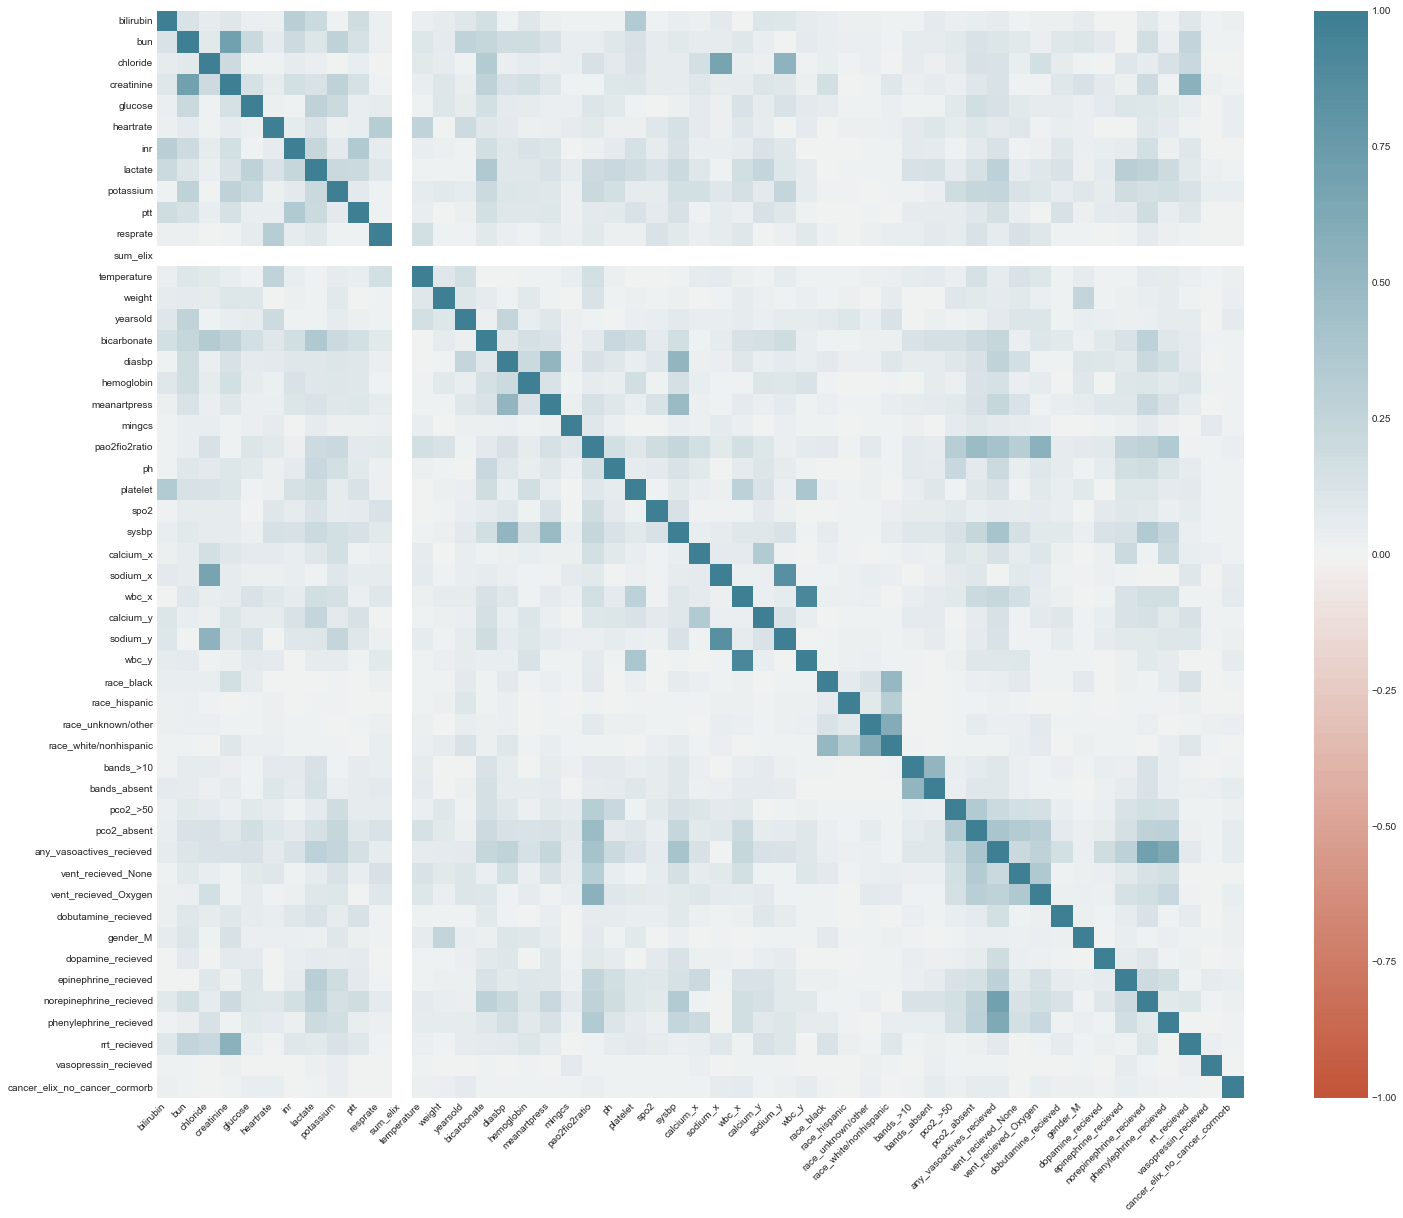

time: 1.78 s (started: 2023-07-27 18:34:31 +08:00)


In [64]:
corr = x_train.corr().abs()

plt.figure(figsize=(25, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [58]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
cor_df=pd.DataFrame(sol)#.sort_values(kind="quicksort") #[-10:0])
cor_df=cor_df.reset_index()
cor_df=cor_df.rename(columns={'level_0': 'corx', 'level_1': 'cory', 0:'corr'})
cor_df2=cor_df[(cor_df['corx']!=cor_df['cory']) & (cor_df['corr']>0.7)].sort_values('corr', ascending=False)
cor_df2

,corx,cory,corr
0,wbc_x,wbc_y,0.916544
1,sodium_x,sodium_y,0.838351
2,bun,creatinine,0.717482
3,any_vasoactives_recieved,norepinephrine_recieved,0.714393


time: 16 ms (started: 2023-07-27 16:51:28 +08:00)


### DROPING one of the 2 columns with correlation >0.7  (depreciated)

In [42]:
# x_train.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')
# x_test.drop(columns=list(cor_df2['corx']), inplace=True, errors='raise')

time: 547 µs


### formatting x and y for modleing

In [65]:
x=np.array(x_train.copy())
y=y_train.copy() #copy of y_train
y=y.astype('int')
#time_interval=4

time: 15 ms (started: 2023-07-27 18:34:44 +08:00)


In [60]:
print(len(x_train),len(x_test))

11290 4828
time: 0 ns (started: 2023-07-27 16:52:01 +08:00)


In [68]:
x_train

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,vasopressin_recieved,cancer_elix_no_cancer_cormorb
0,-0.261860,0.025592,0.044936,0.435041,-0.015390,0.030582,0.485147,0.149716,0.033036,0.080302,...,1,0,1,0,0,1,0,0,0,1
1,-0.046689,-0.092778,-0.013067,-0.207768,0.000000,0.078472,0.000000,-0.032926,0.065443,-0.003189,...,0,0,1,0,0,0,1,0,0,1
2,-0.046689,-0.131194,-0.008669,-0.134895,0.024799,0.049416,-0.224364,-0.032926,0.097243,0.016548,...,1,0,1,0,0,0,0,0,0,1
3,-0.324660,0.000000,-0.031093,1.603348,-0.036101,0.013965,2.636968,-0.551645,0.189228,0.101670,...,0,0,0,0,0,0,0,1,0,1
4,-0.046689,0.101360,0.016858,0.179977,0.080308,-0.037933,-0.109632,-0.032926,0.189228,-0.129870,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0.238814,-0.013643,-0.008669,-0.134895,0.153904,0.010532,-0.109632,0.279406,-0.068061,0.007334,...,0,0,0,0,0,0,0,0,0,1
11286,-0.046689,-0.058640,-0.021991,-0.453505,0.039507,0.064284,0.104965,-0.032926,-0.033690,0.000000,...,0,0,0,0,0,0,0,0,0,1
11287,-0.046689,0.358667,0.052650,0.338727,-0.019394,-0.037933,1.599880,-0.032926,0.097243,-0.004259,...,0,0,1,0,0,0,0,0,0,1
11288,-0.046689,-0.131194,0.025059,0.179977,-0.054035,0.097306,0.395454,0.656884,0.065443,0.057584,...,1,0,1,0,0,1,0,0,0,1


time: 32 ms (started: 2023-07-27 18:35:18 +08:00)


In [67]:
x_test

,bilirubin,bun,chloride,creatinine,glucose,heartrate,inr,lactate,potassium,ptt,...,vent_recieved_None,vent_recieved_Oxygen,dobutamine_recieved,gender_M,dopamine_recieved,epinephrine_recieved,norepinephrine_recieved,phenylephrine_recieved,rrt_recieved,cancer_elix_no_cancer_cormorb
0,2.203204,0.154106,0.000000,0.000000,0.114093,-0.014796,1.197410,0.000000,0.586676,0.087291,...,0,1,0,0,0,0,0,0,0,1
1,-0.049979,-0.226390,0.004273,-0.207768,0.108179,0.067875,-0.214596,0.000000,0.218816,-0.001043,...,0,0,0,0,0,0,0,0,0,1
2,-0.049979,0.081552,-0.017507,0.234997,-0.027605,-0.011031,0.000000,0.000000,-0.413324,-0.001043,...,1,0,0,1,0,0,0,0,0,1
3,-0.049979,0.378735,0.012702,0.901760,0.036314,-0.091791,0.000000,0.000000,0.412670,0.026099,...,0,1,0,1,0,0,0,0,0,1
4,0.092515,0.000000,-0.035714,1.169237,0.012714,0.123547,0.000000,-0.071944,0.000000,0.083194,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,-0.158855,0.119968,-0.064468,0.338727,0.042659,0.079277,-0.104965,0.528088,0.218816,-0.080301,...,0,1,0,1,0,0,0,0,0,1
4824,-0.049979,-0.042897,-0.026519,0.287860,-0.017384,0.007142,-0.214596,0.000000,0.247899,-0.101834,...,0,1,0,1,0,0,0,0,0,1
4825,-0.049979,-0.152370,-0.008669,-0.284807,0.135345,0.095632,0.000000,0.000000,-0.033690,-0.001043,...,0,0,0,1,0,0,0,0,0,1
4826,-0.049979,-0.111386,0.016858,-0.207768,0.065082,0.030921,0.197410,0.245277,0.678661,-0.033853,...,0,0,0,1,0,1,0,1,0,1


time: 31 ms (started: 2023-07-27 18:35:10 +08:00)


In [66]:
np.array(x_test).shape

(4828, 50)

time: 16 ms (started: 2023-07-27 18:34:59 +08:00)


In [61]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

time: 0 ns (started: 2023-07-27 16:52:03 +08:00)


In [8]:
def data_import(allFiles):
    """
    function to import x_train, x_test, y_train, and y_test using glob of the data/final folder.
    """
    for name in allFiles:
        if 'test' in name:
            if 'x_' in name:
                x_test = pd.read_csv(name,  index_col=0)
            elif '_y_' in name:
                 y_test = pd.read_csv(name,  index_col=0)
            else:
                icu_test=pd.read_csv(name,  index_col=0)
        elif 'train' in name:
            if 'x_' in name:
                x_train = pd.read_csv(name,  index_col=0)
            elif '_y_' in name:
                 y_train = pd.read_csv(name,  index_col=0)
            else:
                icu_train=pd.read_csv(name,  index_col=0)
            
    return(x_train, x_test, y_train, y_test, icu_train, icu_test)

time: 0 ns (started: 2023-07-27 18:33:00 +08:00)


In [9]:
allFiles = glob.glob(str(repository_path)+ '/data/final/{}_{}/'.format(date,folder) + "*.csv")

x_train, x_test, y_train, y_test, icu_train, icu_test= data_import(allFiles)

time: 156 ms (started: 2023-07-27 18:33:04 +08:00)


In [13]:
np.array(x_test).shape

(4828, 50)

time: 16 ms (started: 2023-07-27 18:33:55 +08:00)


In [65]:
x

array([[-0.26185951,  0.02559212,  0.04493616, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04668917, -0.09277837, -0.01306653, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04668917, -0.1311944 , -0.00866921, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.04668917,  0.35866674,  0.05265024, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04668917, -0.1311944 ,  0.02505878, ...,  0.        ,
         0.        ,  1.        ],
       [-0.04668917, -0.22638953,  0.01270184, ...,  0.        ,
         0.        ,  1.        ]])

time: 0 ns (started: 2023-07-27 16:53:14 +08:00)


In [62]:
len(list(x_train))

51

time: 0 ns (started: 2023-07-27 16:52:57 +08:00)


In [66]:
def save_df(df, df_name='default', rel_path='/data/final/'):
    """
    simple function for saving result table. uses the date and supplied df name and saves to the savepath specified above.
    """
    global folder
    
    save_path= str(repository_path)+rel_path
    
    address=save_path+'{}_{}/'.format(date,folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    else:
        print(address)
        
    if address.endswith('/')==False:
        address= address+'/'
        
    if df_name == 'default':
        df_name =[x for x in globals() if globals()[x] is df][0]
        
    pd.DataFrame(df).to_csv(Path(address+'{}_{}.csv'.format(date, df_name)))


time: 0 ns (started: 2023-07-27 16:53:19 +08:00)


In [67]:
if save_boolean==True:
    save_df(x_train, 'x_train_final', rel_path='/data/final/')
    save_df(x_test, 'x_test_final', rel_path='/data/final/')
    save_df(y_train, 'y_train_final', rel_path='/data/final/')
    save_df(y_test, 'y_test_final', rel_path='/data/final/')
    
    # save_df(x_longneg, 'x_longneg_final', rel_path='/data/final/')
    # save_df(y_longneg, 'y_longneg_final', rel_path='/data/final/')
    
    save_df(z_stay_id, 'icustay_train', rel_path='/data/final/') #just added, need to rerun all models. 12-19-19
    save_df(z_stay_id_test, 'icustay_test', rel_path='/data/final/')
    #save_df(z_stay_id_longneg, 'icustay_longneg', rel_path='/data/final/')


c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
c:\Users\csfhe\Documents\RA\mimiciii-antibiotics-opensource\notebooks/data/final/07242023_24_hr_window/
time: 985 ms (started: 2023-07-27 16:53:55 +08:00)
